# Taller colaborativo Semana 4 – XAI y sesgos en modelo de ciberseguridad

**Curso:** Aprendizaje Automático  
**Grupo:** 9  
**Integrantes:** Angie Blandón, Enrique Pérez, Jimmy Rodríguez, Fredy Aguirre  

En este cuaderno se entrena un modelo supervisado para predecir el **resultado de un incidente de ciberseguridad** (`outcome`) utilizando el dataset `cybersecurity synthesized data.csv`.  
Además, se aplican técnicas de **explicabilidad (XAI)** para analizar cómo el modelo toma decisiones, revisar posibles sesgos y reflexionar sobre implicaciones éticas y sociales.


## 1. Configuración inicial

Esta sección prepara el entorno de trabajo.  



In [1]:
# Instalación opcional de librerías en Colab (descomentar si hace falta)
!pip install shap lime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import shap
from lime.lime_tabular import LimeTabularExplainer

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Ruta al dataset: ajusta según tu estructura de carpetas
DATA_PATH = "cybersecurity synthesized data.csv"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f96d8cb9b40950b07d21936ebb232b80c6de970349a9a17adb0cea9b03884479
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


## 2. Carga del dataset y descripción general

En esta sección se carga el archivo CSV y se revisan sus dimensiones, tipos de datos y algunas estadísticas descriptivas básicas.  
El objetivo es tener una primera impresión de la estructura de la información disponible.


In [3]:
df = pd.read_csv(DATA_PATH)

print("Dimensiones del dataframe (filas, columnas):", df.shape)
display(df.head())
print("\nInformación del dataframe:")
display(df.info())
print("\nEstadísticos descriptivos:")
display(df.describe(include="all"))


Dimensiones del dataframe (filas, columnas): (100000, 15)


,attack_type,target_system,outcome,timestamp,attacker_ip,target_ip,data_compromised_GB,attack_duration_min,security_tools_used,user_role,location,attack_severity,industry,response_time_min,mitigation_method
0,Phishing,Cloud Service,Failure,2024-04-03 11:13:15.083419,21.166.79.4,23.20.50.78,15.31,300,Firewall,Employee,Australia,2,Energy,164,Containment
1,DDoS,Email Server,Success,2024-02-03 20:51:56.083463,187.180.150.169,34.160.58.218,65.05,242,Endpoint Detection,Admin,Brazil,10,Retail,64,Reset Credentials
2,Zero-Day Exploit,Cloud Service,Success,2024-07-19 18:40:05.083472,57.161.159.140,213.142.125.206,48.99,120,Firewall,External User,Germany,7,Finance,87,Quarantine
3,SQL Injection,Email Server,Failure,2023-12-08 00:54:17.083478,207.108.16.104,4.104.193.49,16.29,286,MFA,Employee,Russia,3,Healthcare,23,Patch
4,Zero-Day Exploit,IoT Device,Failure,2024-07-23 05:38:20.083483,98.122.15.31,57.66.53.194,87.66,4,Firewall,Contractor,UK,6,Finance,129,Containment



Información del dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   attack_type          100000 non-null  object 
 1   target_system        100000 non-null  object 
 2   outcome              100000 non-null  object 
 3   timestamp            100000 non-null  object 
 4   attacker_ip          100000 non-null  object 
 5   target_ip            100000 non-null  object 
 6   data_compromised_GB  100000 non-null  float64
 7   attack_duration_min  100000 non-null  int64  
 8   security_tools_used  100000 non-null  object 
 9   user_role            100000 non-null  object 
 10  location             100000 non-null  object 
 11  attack_severity      100000 non-null  int64  
 12  industry             100000 non-null  object 
 13  response_time_min    100000 non-null  int64  
 14  mitigation_method    100000 non-null  obj

None


Estadísticos descriptivos:


,attack_type,target_system,outcome,timestamp,attacker_ip,target_ip,data_compromised_GB,attack_duration_min,security_tools_used,user_role,location,attack_severity,industry,response_time_min,mitigation_method
count,100000,100000,100000,100000,100000,100000,100000.000000,100000.000000,100000,100000,100000,100000.000000,100000,100000.000000,100000
unique,8,8,2,100000,100000,99997,NaN,NaN,8,4,10,NaN,8,NaN,5
top,Brute Force,Cloud Service,Success,2024-07-21 20:24:07.650625,116.168.157.39,166.34.142.134,NaN,NaN,SIEM,Admin,Brazil,NaN,Government,NaN,Patch
freq,12605,12641,50030,1,1,2,NaN,NaN,12668,25114,10133,NaN,12645,NaN,20151
mean,NaN,NaN,NaN,NaN,NaN,NaN,50.062586,151.070590,NaN,NaN,NaN,5.498990,NaN,90.454450,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,28.829756,86.733278,NaN,NaN,NaN,2.869718,NaN,51.905376,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,25.170000,76.000000,NaN,NaN,NaN,3.000000,NaN,46.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,50.060000,151.000000,NaN,NaN,NaN,5.000000,NaN,90.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,74.970000,226.000000,NaN,NaN,NaN,8.000000,NaN,135.000000,NaN


## 3. Calidad de datos y distribución de la variable objetivo

Antes de entrenar cualquier modelo es importante revisar:

- Valores faltantes.
- Filas duplicadas.
- Distribución de la variable objetivo `outcome` para detectar posibles desbalances de clase.


Valores faltantes por columna:


,0
attack_type,0
target_system,0
outcome,0
timestamp,0
attacker_ip,0
target_ip,0
data_compromised_GB,0
attack_duration_min,0
security_tools_used,0
user_role,0



Filas duplicadas en el dataset: 0

Distribución de la variable objetivo:


,count
outcome,
Success,50030
Failure,49970



Distribución relativa (%):


,proportion
outcome,
Success,50.03
Failure,49.97


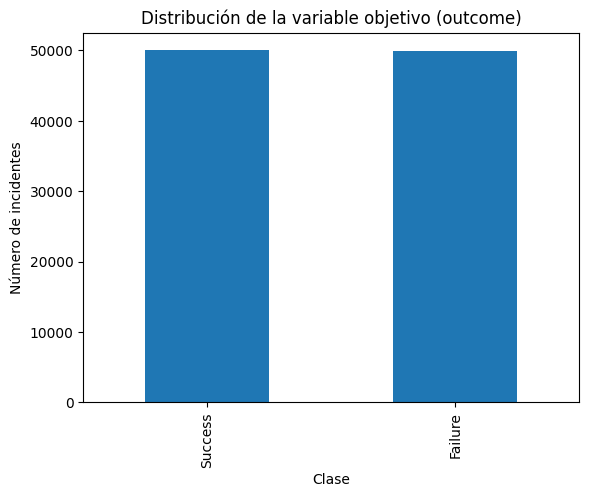

In [4]:
# Valores faltantes por columna
na_counts = df.isna().sum().sort_values(ascending=False)
print("Valores faltantes por columna:")
display(na_counts)

# Filas duplicadas
duplicate_rows = df.duplicated().sum()
print(f"\nFilas duplicadas en el dataset: {duplicate_rows}")

# Variable objetivo
target_col = "outcome"

# Distribución de la variable objetivo
print("\nDistribución de la variable objetivo:")
display(df[target_col].value_counts())
print("\nDistribución relativa (%):")
display(df[target_col].value_counts(normalize=True) * 100)

# Gráfico de barras de la variable objetivo
plt.figure()
df[target_col].value_counts().plot(kind="bar")
plt.title("Distribución de la variable objetivo (outcome)")
plt.xlabel("Clase")
plt.ylabel("Número de incidentes")
plt.show()


## 4. Ingeniería de características

En esta etapa se transforman algunas columnas para hacerlas más útiles para el modelo:

- A partir de `timestamp` se generan:
  - `hour` (hora del día),
  - `dayofweek` (día de la semana),
  - `is_weekend` (fin de semana: 1, entre semana: 0).
- Se eliminan columnas de alta cardinalidad o que actúan como identificadores directos:
  - `attacker_ip`,
  - `target_ip`,
  - `timestamp` original (una vez creadas las nuevas variables de tiempo).

Después se separan las variables predictoras (`X`) de la variable objetivo (`y`) y se identifican columnas numéricas y categóricas.


In [5]:
df_model = df.copy()

# Conversión de timestamp a tipo datetime
df_model["timestamp"] = pd.to_datetime(df_model["timestamp"])

# Variables derivadas de tiempo
df_model["hour"] = df_model["timestamp"].dt.hour
df_model["dayofweek"] = df_model["timestamp"].dt.dayofweek
df_model["is_weekend"] = df_model["dayofweek"].isin([5, 6]).astype(int)

# Eliminación de columnas de alta cardinalidad o identificadores directos
cols_to_drop = ["attacker_ip", "target_ip", "timestamp"]
cols_to_drop = [c for c in cols_to_drop if c in df_model.columns]
df_model = df_model.drop(columns=cols_to_drop)

# Definición de variable objetivo y predictores
y = df_model[target_col]
X = df_model.drop(columns=[target_col])

# Identificación de columnas categóricas y numéricas
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Columnas categóricas:", cat_cols)
print("Columnas numéricas:", num_cols)


Columnas categóricas: ['attack_type', 'target_system', 'security_tools_used', 'user_role', 'location', 'industry', 'mitigation_method']
Columnas numéricas: ['data_compromised_GB', 'attack_duration_min', 'attack_severity', 'response_time_min', 'hour', 'dayofweek', 'is_weekend']


## 5. División de datos y preprocesamiento

Se divide el dataset en conjuntos de entrenamiento y prueba utilizando un **split estratificado**, de modo que se mantenga la proporción de clases en `outcome`.

Para el preprocesamiento se aplica:

- **One-Hot Encoding** a las variables categóricas.
- Paso directo (*passthrough*) de las variables numéricas.

Todo se integra en un `ColumnTransformer` que luego se encadena con el modelo en un `Pipeline`.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

rf_clf = RandomForestClassifier(
    n_estimators=150,      # un poco menos de árboles
    max_depth=8,           # limitar la profundidad de los árboles
    min_samples_split=5,   # evitar splits demasiado finos
    min_samples_leaf=5,    # hojas mínimas con más muestras
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE
)


pipe_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", rf_clf)
])

pipe_rf


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['attack_type',
                                                   'target_system',
                                                   'security_tools_used',
                                                   'user_role', 'location',
                                                   'industry',
                                                   'mitigation_method']),
                                                 ('num', 'passthrough',
                                                  ['data_compromised_GB',
                                                   'attack_duration_min',
                                                   'attack_severity',
                                                   'response_time_min', 'hour',
                                                   'dayofweek',
                                                   'is_weekend'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        min_samples_leaf=5, min_samples_split=5,
                                        n_estimators=150, n_jobs=-1,
                                        random_state=42))])

## 6. Entrenamiento del modelo base y validación

En esta sección se entrena un **Random Forest** como modelo base.  
Se realiza una validación cruzada para estimar el rendimiento y luego se ajusta el modelo con todos los datos de entrenamiento.


In [7]:
# Validación cruzada con accuracy
cv_scores = cross_val_score(
    pipe_rf,
    X_train,
    y_train,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

print("Resultados de validación cruzada (accuracy):", cv_scores)
print("Accuracy promedio:", cv_scores.mean())

# Entrenamiento final del modelo
pipe_rf.fit(X_train, y_train)


Resultados de validación cruzada (accuracy): [0.50031875 0.49953126 0.5080252 ]
Accuracy promedio: 0.502625067501664


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['attack_type',
                                                   'target_system',
                                                   'security_tools_used',
                                                   'user_role', 'location',
                                                   'industry',
                                                   'mitigation_method']),
                                                 ('num', 'passthrough',
                                                  ['data_compromised_GB',
                                                   'attack_duration_min',
                                                   'attack_severity',
                                                   'response_time_min', 'hour',
                                                   'dayofweek',
                                                   'is_weekend'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        min_samples_leaf=5, min_samples_split=5,
                                        n_estimators=150, n_jobs=-1,
                                        random_state=42))])

### 6.1. Evaluación en el conjunto de prueba

Se evalúa el modelo entrenado utilizando diversas métricas:

- Accuracy global.
- Precision, Recall y F1-score por clase.
- Matriz de confusión.


Reporte de clasificación en el conjunto de prueba:

              precision    recall  f1-score   support

     Failure       0.49      0.48      0.49      9994
     Success       0.49      0.50      0.50     10006

    accuracy                           0.49     20000
   macro avg       0.49      0.49      0.49     20000
weighted avg       0.49      0.49      0.49     20000



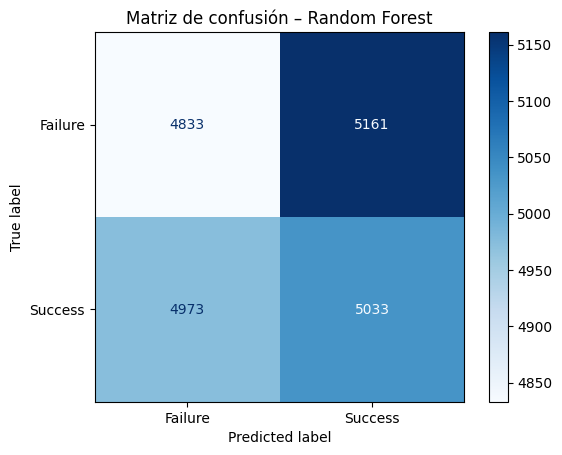

In [8]:
y_pred = pipe_rf.predict(X_test)

print("Reporte de clasificación en el conjunto de prueba:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=pipe_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_rf.classes_)
disp.plot(cmap="Blues")
plt.title("Matriz de confusión – Random Forest")
plt.show()


## 7. Importancia de características según el modelo base

Antes de aplicar técnicas XAI se puede revisar la importancia de variables reportada por el propio Random Forest.  
Esto entrega una primera aproximación de qué atributos contribuyen más a la clasificación.


,feature,importance
51,data_compromised_GB,0.133600
54,response_time_min,0.112682
52,attack_duration_min,0.112071
55,hour,0.074680
53,attack_severity,0.053115
56,dayofweek,0.042428
46,mitigation_method_Block IP,0.012450
24,user_role_Admin,0.011838
15,target_system_Web Server,0.011266
20,security_tools_used_MFA,0.011003


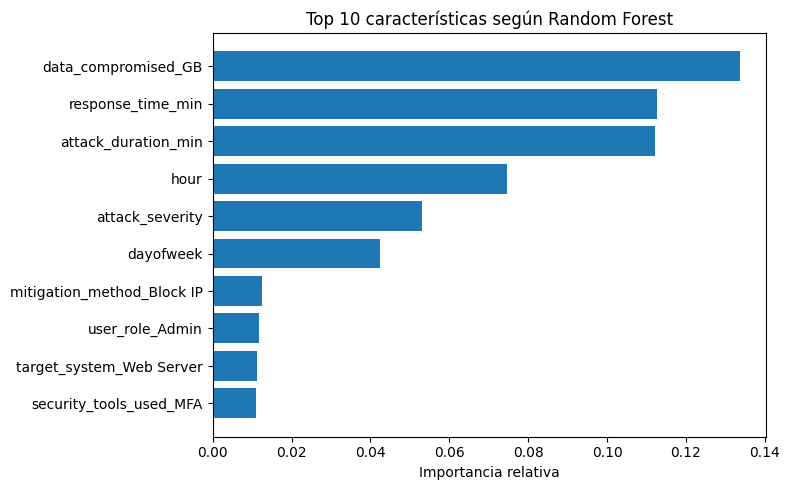

In [9]:
# Extracción del modelo Random Forest ya entrenado
rf_fitted = pipe_rf.named_steps["clf"]

# Obtener nombres de las columnas tras One-Hot Encoding
ohe = pipe_rf.named_steps["preprocess"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

feature_names = list(ohe_feature_names) + num_cols

importances = rf_fitted.feature_importances_

feat_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

display(feat_importance.head(15))

# Gráfico de las 10 características más importantes
top_k = 10
top = feat_importance.head(top_k)
plt.figure(figsize=(8, 5))
plt.barh(top["feature"], top["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importancia relativa")
plt.title(f"Top {top_k} características según Random Forest")
plt.tight_layout()
plt.show()


## 8. Explicabilidad global y local con SHAP

SHAP (SHapley Additive exPlanations) permite:

- Medir la contribución promedio de cada variable a las predicciones del modelo.
- Visualizar cómo cambia la salida del modelo cuando varía una característica específica.
- Analizar explicaciones locales para instancias individuales.

A continuación se utilizan gráficos tipo summary plot y dependence plot.


/tmp/ipython-input-471119766.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


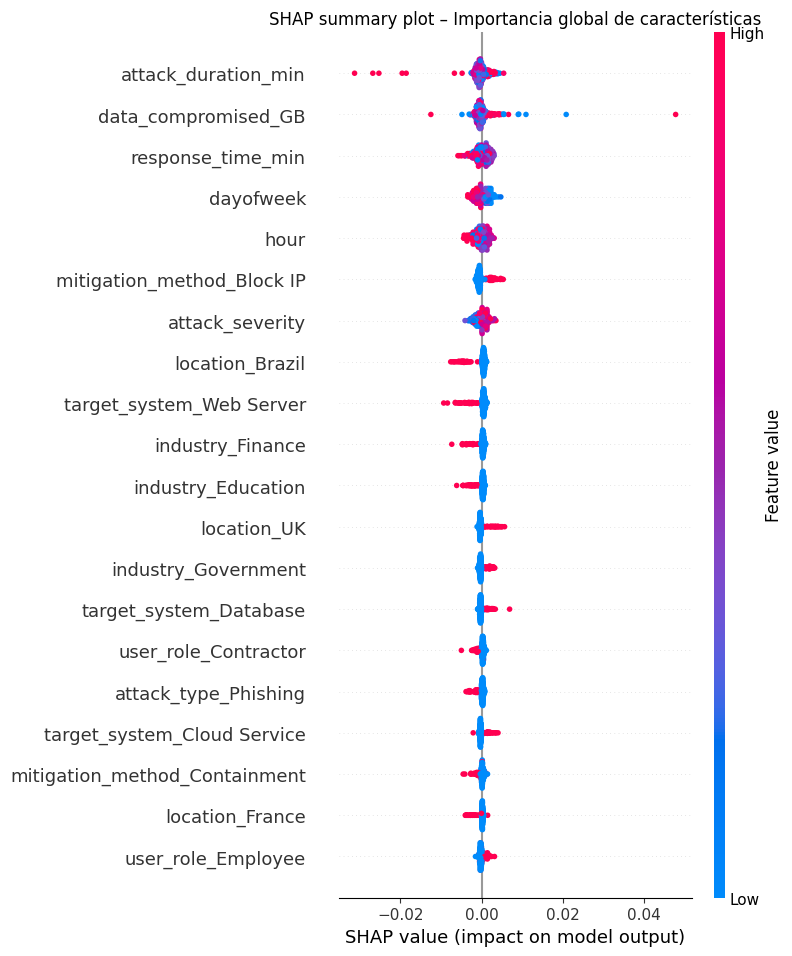

In [11]:
# 1. Transformar datos de prueba, convertir a array denso y asegurar tipo float
X_test_transformed = pipe_rf.named_steps["preprocess"].transform(X_test).toarray()
X_test_transformed = X_test_transformed.astype(float)

# 2. Crear TreeExplainer para el RandomForest ya entrenado
explainer = shap.TreeExplainer(rf_fitted)

# 3. Trabajar con una muestra aleatoria más pequeña
import numpy as np

sample_size = min(300, X_test_transformed.shape[0])  # antes: 2000
idx = np.random.choice(X_test_transformed.shape[0], size=sample_size, replace=False)
X_test_sample = X_test_transformed[idx]

# 4. Calcular valores SHAP (desactivando la comprobación de aditividad)
# Based on the kernel state, explainer.shap_values returns a 3D array (samples, features, classes).
shap_values_all_classes = explainer.shap_values(X_test_sample, check_additivity=False)

# 5. Summary plot para la clase 1 (si es binario)
# For a 3D shap_values array, select the class by slicing the last dimension.
# Assuming class 0 is 'Failure' and class 1 is 'Success' from the classification report.
# shap_values_all_classes[:, :, 1] selects SHAP values for class 1 across all samples.
shap.summary_plot(
    shap_values_all_classes[:, :, 1],
    X_test_sample,
    feature_names=feature_names,
    show=False
)
plt.title("SHAP summary plot – Importancia global de características")
plt.show()

Característica seleccionada para dependence plot: data_compromised_GB


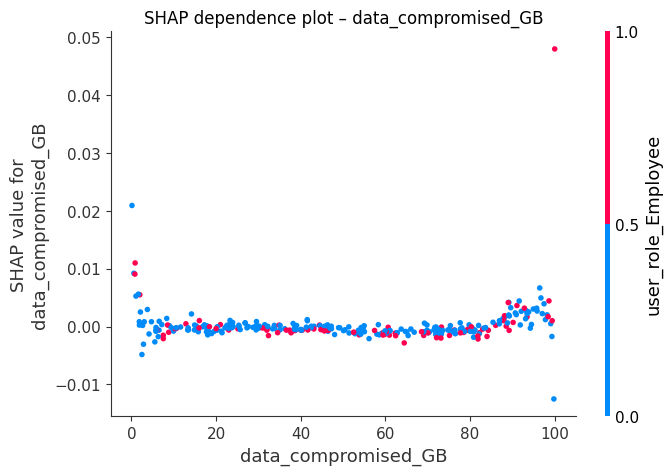

In [13]:
# Dependence plot para la característica más importante
top_feature = feat_importance["feature"].iloc[0]
print("Característica seleccionada para dependence plot:", top_feature)

# Corregir la forma de shap_values: usar los valores SHAP para la clase 1 (Success)
shap.dependence_plot(
    top_feature,
    shap_values_all_classes[:, :, 1], # Usar SHAP values para la clase 1 (Success) en todos los ejemplos
    X_test_sample,
    feature_names=feature_names,
    show=False
)
plt.title(f"SHAP dependence plot – {top_feature}")
plt.show()

## 9. Explicaciones locales con LIME

LIME (Local Interpretable Model-agnostic Explanations) aproxima el comportamiento del modelo alrededor de una instancia concreta mediante un modelo interpretable.  
Es útil para:

- Explicar decisiones individuales.
- Comunicar a personal no técnico por qué un incidente fue clasificado de cierta manera.


In [15]:
# Preparar datos transformados de entrenamiento
X_train_transformed = pipe_rf.named_steps["preprocess"].transform(X_train).toarray()

class_names = list(pipe_rf.classes_)

explainer_lime = LimeTabularExplainer(
    training_data=X_train_transformed, # Pass the dense array directly
    feature_names=feature_names,
    class_names=class_names,
    discretize_continuous=True,
    verbose=False,
    mode="classification"
)

# Selección de una instancia de prueba para explicar
idx = 0  # puedes cambiar el índice para analizar otros ejemplos
instance = X_test.iloc[idx:idx+1]
instance_transformed = pipe_rf.named_steps["preprocess"].transform(instance).toarray() # Also convert instance to dense array

print("Instancia seleccionada:")
display(instance)
print("\nEtiqueta verdadera:", y_test.iloc[idx])
print("Predicción del modelo:", pipe_rf.predict(instance)[0])

# Generar explicación LIME
exp = explainer_lime.explain_instance(
    data_row=instance_transformed[0],
    predict_fn=pipe_rf.named_steps["clf"].predict_proba,
    num_features=10
)

# Mostrar la explicación en modo texto
print("\nExplicación LIME (características y contribución):")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

Instancia seleccionada:


,attack_type,target_system,data_compromised_GB,attack_duration_min,security_tools_used,user_role,location,attack_severity,industry,response_time_min,mitigation_method,hour,dayofweek,is_weekend
17995,Phishing,Cloud Service,25.24,124,SIEM,External User,Canada,1,Retail,73,Block IP,0,4,0



Etiqueta verdadera: Success
Predicción del modelo: Failure

Explicación LIME (características y contribución):
location_Brazil <= 0.00: 0.0049
target_system_Web Server <= 0.00: 0.0039
mitigation_method_Block IP > 0.00: 0.0032
industry_Finance <= 0.00: 0.0029
attack_type_Phishing > 0.00: -0.0029
industry_Education <= 0.00: 0.0028
location_UK <= 0.00: -0.0026
location_France <= 0.00: 0.0024
46.00 < response_time_min <= 90.00: 0.0022
industry_Government <= 0.00: -0.0020


### 10. Comparación entre explicaciones SHAP y LIME

---

#### a) Variables más influyentes según SHAP (y Random Forest)

- SHAP confirma que las variables de **impacto técnico** (datos comprometidos, duración, tiempo de respuesta) son las que más influyen en el modelo.
- Las variables temporales (`hour`, `dayofweek`, `is_weekend`) también aportan información relevante, quizá porque ciertos ataques se concentran en horarios o días específicos.
- Los roles de usuario, el sector (`industry`) y el método de mitigación aparecen como factores secundarios pero **no despreciables**.

---

#### b) Variables destacadas en LIME

- En este caso puntual, LIME no solo resalta variables numéricas (como el rango de `response_time_min`), sino varias variables **categóricas** relacionadas con ubicación, tipo de sistema, industria y método de mitigación.
- Esto muestra que, para un incidente específico, el modelo combina **señales técnicas** con **señales contextuales** (país, sector, tipo de ataque) para llegar a su decisión.

---

#### c) Similitudes y diferencias SHAP vs LIME

**Similitudes:**

- Ambas técnicas reconocen que los **tiempos** (`response_time_min`) y características técnicas del incidente son relevantes.
- Tanto SHAP como LIME refuerzan la idea de que el **contexto del incidente** (tipo de ataque, sistema objetivo, industria) sí influye en la decisión, aunque globalmente pese menos que las variables numéricas principales.

**Diferencias:**

- **SHAP** ofrece una visión **global**: ordena las variables por importancia promedio en todo el conjunto de prueba.  
  Ahí dominan claramente las numéricas (`data_compromised_GB`, `attack_duration_min`, `response_time_min`).
- **LIME** ofrece una visión **local**: se enfoca en un solo caso y puede destacar variables categóricas que, en ese incidente concreto, tuvieron más influencia que otras que globalmente son más importantes (por ejemplo, combinaciones de `location_*`, `industry_*` o `attack_type_Phishing`).
- En el ejemplo analizado, LIME da bastante peso a la **combinación de industria y ubicación**, mientras que en SHAP esas mismas variables aparecen más abajo en el ranking global.

---

#### d) Relación con el contexto de ciberseguridad

Desde la perspectiva de ciberseguridad, tiene sentido que el modelo use principalmente:

- **Impacto** (cantidad de datos comprometidos),
- **Duración del ataque**, y
- **Tiempo de respuesta**

como señales fuertes para evaluar el resultado del incidente.

Al mismo tiempo, el hecho de que LIME destaque el **sector**, el **país** y el **tipo de ataque** en un caso individual sugiere que, en ciertos entornos (por ejemplo, determinadas industrias o ubicaciones), el modelo “ajusta” su decisión, posiblemente debido a patrones presentes en los datos de entrenamiento.


### 11. Reflexiones sobre transparencia, sesgos y riesgos éticos

---

#### 11.1 Transparencia del modelo

**Sin XAI:**

- Un Random Forest con cientos de árboles y muchas variables es, en la práctica, una **caja negra**: es difícil justificar por qué un incidente concreto se etiquetó como `Success` o `Failure`.
- Además, el rendimiento del modelo en el notebook es cercano al azar (**accuracy ≈ 0.49**), lo que hace todavía más delicado confiar ciegamente en sus salidas.

**Con SHAP y LIME:**

- **SHAP** ayuda a entender qué variables pesan más de forma global y cómo su variación cambia la probabilidad de cada clase.
- **LIME** permite explicar **decisiones individuales**, lo que es clave para que un analista de seguridad pueda discutir un caso concreto.

Juntas, estas técnicas permiten construir explicaciones que se pueden presentar a:

- Equipos técnicos (para ajustar el modelo),
- Equipos de auditoría/compliance (para justificar decisiones),
- Responsables de negocio (para entender riesgos y priorizaciones).

**Equipos de seguridad y auditoría podrían usar estas explicaciones para:**

- Revisar si el modelo está ignorando señales importantes.
- Justificar por qué ciertos incidentes se escalan como críticos y otros no.
- Documentar criterios de priorización ante auditorías o incidentes regulatorios.

---

#### 11.2 Riesgos éticos y sociales

Conviene pensar en dos tipos de errores:

**Falso negativo:**

> Un incidente que en realidad debería tratarse como crítico / “exitoso para el atacante” pero el modelo lo clasifica como menos grave o lo minimiza.

**Riesgos:**

- El incidente podría no ser atendido a tiempo.
- Aumenta la probabilidad de fuga de datos o interrupciones de servicio.
- Se pone en riesgo la información de usuarios, empresas o servicios críticos.

**Falso positivo:**

> Un incidente no tan grave que el modelo clasifica como muy crítico.

**Riesgos:**

- Sobrecarga de los equipos de respuesta.
- Desviación de recursos hacia casos menos urgentes.
- Posible “fatiga de alertas”, donde el personal empieza a desconfiar de las nuevas alertas.

**Posibles sesgos en los datos:**

A partir de los resultados, variables como:

- `industry_Finance`, `industry_Education`, `industry_Government`
- `location_*`
- `user_role_*`

están influyendo en las decisiones.

Si el dataset tiene más incidentes registrados en ciertos países, industrias o tipos de usuario, el modelo puede aprender patrones que:

- **Sobre-representan** el riesgo en esos grupos.
- **Subestiman** el riesgo en otros sectores/países menos presentes en los datos.

Esto puede generar decisiones sistemáticamente sesgadas, por ejemplo:

- Tratar siempre a ciertos sectores con más sospecha.
- Ignorar industrias con pocos datos históricos, aunque en realidad estén muy expuestas.

---

#### 11.3 Mejoras y recomendaciones

Basado en lo observado en el notebook (rendimiento bajo, fuerte peso de algunas variables, mezcla de técnicas XAI), se pueden plantear mejoras en varios niveles:

**A nivel de modelo:**

- Explorar otros modelos supervisados (por ejemplo, métodos de **boosting**) o ajustar más a fondo los hiperparámetros del Random Forest, ya que actualmente la **accuracy ≈ 0.49**.
- Evaluar el modelo con métricas que reflejen mejor el coste de los errores (por ejemplo, **F1 por clase** o métricas ponderadas para la clase de mayor riesgo).
- Revisar la calidad de las etiquetas de *outcome* (al ser un dataset sintético, la lógica de generación podría influir mucho en la capacidad de aprendizaje).

**A nivel de variables:**

- Analizar si tiene sentido introducir **nuevas variables derivadas** (por ejemplo, agrupar industrias en categorías de riesgo, agrupar países por región).
- Ver si algunas variables aportan **más ruido que información** y evaluar su eliminación.
- Verificar si hay alguna variable que contenga información “demasiado directa” sobre la etiqueta y genere dependencia espuria.

**A nivel organizacional:**

- Acordar que el modelo **no reemplace** la evaluación humana, sino que actúe como apoyo (*human-in-the-loop*).
- Definir procesos de:
  - Reentrenamiento periódico con datos más recientes.
  - Revisión de métricas y **auditoría del comportamiento** del modelo.
  - Documentación de versiones y cambios (**trazabilidad**).


### 12. Reflexión final sobre el aprendizaje

---

#### a) ¿Qué aprendiste sobre cómo el modelo toma decisiones?

- Que el modelo se apoya principalmente en variables técnicas relacionadas con **impacto** (datos comprometidos) y **tiempos** (respuesta y duración).
- Que el **contexto** (rol del usuario, industria, país, tipo de ataque) también influye, sobre todo cuando miras casos individuales con **LIME**.
- Que sin técnicas de **XAI** sería muy difícil justificar por qué un incidente específico se clasificó de cierta manera.

---

#### b) ¿Hay alguna variable con peso excesivo? ¿Es razonable?

- `data_compromised_GB`, `response_time_min` y `attack_duration_min` tienen la mayor importancia, pero ninguna domina por completo el modelo.
- Se puede considerar razonable que el modelo dé más importancia a la cantidad de **datos afectados** y a los **tiempos**, ya que son indicadores clave del impacto de un incidente.
- Aun así, conviene vigilar que el modelo no ignore sistemáticamente otras señales (por ejemplo, que siempre trate como menos graves ciertos tipos de ataque o ciertos sectores solo porque hay pocos ejemplos).

---

#### c) Problemas si se implementa sin explicabilidad

- Las decisiones del modelo serían difíciles de justificar frente a:
  - Equipos técnicos,
  - Equipos de auditoría,
  - Usuarios afectados o reguladores.
- Se podrían consolidar **sesgos** sin que nadie se dé cuenta:
  - Por ejemplo, priorizar sistemáticamente ciertos sectores o ubicaciones por cómo está distribuido el dataset.
- El equipo de seguridad podría dejar de cuestionar las salidas del sistema y depender en exceso de un modelo que, en este caso, todavía tiene un rendimiento **cercano al azar**.
